# Example Model Explanations with Seldon
Seldon core supports various out-of-the-box explainers that leverage the [Alibi ML Expalinability](https://github.com/SeldonIO/alibi) open source library.

In this notebook we show how you can use the pre-packaged explainer functionality that simplifies the creation of advanced AI model explainers.

Seldon provides the following out-of-the-box pre-packaged explainers:
* Anchor Tabular Explainer 
    * A black box Explainer that uses the [anchor technique](https://docs.seldon.io/projects/alibi/en/latest/methods/Anchors.html) for tabular data
    * It basically answers the question of what are the most "powerul" or "important" features in a tabular prediction
* Anchor Image Explainer
    * A black box Explainer that uses the [anchor technique](https://docs.seldon.io/projects/alibi/en/latest/methods/Anchors.html) for image data
    * It basically answers the question of what are the most "powerul" or "important" pixels in an image prediction
* Anchor Text Explainer
    * A black box Explainer that uses the [anchor technique](https://docs.seldon.io/projects/alibi/en/latest/methods/Anchors.html) for text data
    * It basically answers the question of what are the most "powerul" or "important" tokens in a text prediction
* Kernel Shap Explainer
    * A black box Explainer that uses the [kernel shap technique](https://docs.seldon.io/projects/alibi/en/latest/methods/Anchors.html) for tabular data
    * It provides postive and negative feature attributions that contributed to the predictions
* Integrated Gradient Explainer
    * A white box explainer that uses the [Integrated Gradients technique](https://docs.seldon.io/projects/alibi/en/latest/methods/Anchors.html) for Keras models
    * It provides importance values for each feature
* Tree Shap Explainer
    * A white box explainer that uses the [TreeShap technqiue](https://docs.seldon.io/projects/alibi/en/latest/methods/Anchors.html) for tree based models
    * It provides positive and negative feature attributions that contributed to the predictions

## Running this notebook

For the [ImageNet Model](#Imagenet-Model) you will need:

 - [alibi package](https://pypi.org/project/alibi/) (```pip install alibi```)
 
 This should install the required package dependencies, if not please also install:
 - [Pillow package](https://pypi.org/project/Pillow/) (```pip install Pillow```)
 - [matplotlib package](https://pypi.org/project/matplotlib/) (```pip install matplotlib```)
 - [tensorflow package](https://pypi.org/project/tensorflow/) (```pip install tensorflow```)

You will also need to start Jupyter with settings to allow for large payloads, for example:

```
jupyter notebook --NotebookApp.iopub_data_rate_limit=1000000000
```

## Setup Seldon Core

Follow the instructions to [Setup Cluster](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Setup-Cluster) with [Ambassador Ingress](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Ambassador) and [Install Seldon Core](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Install-Seldon-Core).

 Then port-forward to that ingress on localhost:8003 in a separate terminal either with:

 * Ambassador: `kubectl port-forward $(kubectl get pods -n seldon -l app.kubernetes.io/name=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8003:8080`
 * Istio: `kubectl port-forward $(kubectl get pods -l istio=ingressgateway -n istio-system -o jsonpath='{.items[0].metadata.name}') -n istio-system 8003:80`

### Create Namespace for experimentation

We will first set up the namespace of Seldon where we will be deploying all our models

In [1]:
!kubectl create namespace seldon

Error from server (AlreadyExists): namespaces "seldon" already exists


And then we will set the current workspace to use the seldon namespace so all our commands are run there by default (instead of running everything in the default namespace.)

In [2]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "kind-kind" modified.


## Income Prediction Model with Anchors Explainer
The model and explainer used here can be trained yourself following the full example in the [Alibi Anchor Explanations for Income Notebook](https://docs.seldon.io/projects/alibi/en/latest/examples/anchor_tabular_adult.html) in the Alibi project documentation.

Note we used a python3.6 and version 0.5.2 of Alibi.

In [3]:
%%writefile resources/income_explainer.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: income
spec:
  name: income
  annotations:
    seldon.io/rest-timeout: "100000"
  predictors:
  - graph:
      children: []
      implementation: SKLEARN_SERVER
      modelUri: gs://seldon-models/sklearn/income/model-0.23.2
      name: classifier
    explainer:
      type: AnchorTabular
      modelUri: gs://seldon-models/sklearn/income/explainer-py36-0.5.2
    name: default
    replicas: 1

Overwriting resources/income_explainer.yaml


In [4]:
!kubectl apply -f resources/income_explainer.yaml

seldondeployment.machinelearning.seldon.io/income created


In [5]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=income -o jsonpath='{.items[0].metadata.name}')

Waiting for deployment "income-default-0-classifier" rollout to finish: 0 of 1 updated replicas are available...
deployment "income-default-0-classifier" successfully rolled out


In [6]:
!kubectl rollout status deploy/income-default-explainer

Waiting for deployment "income-default-explainer" rollout to finish: 0 of 1 updated replicas are available...
deployment "income-default-explainer" successfully rolled out


In [7]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(deployment_name="income",namespace="seldon", gateway="ambassador", gateway_endpoint="localhost:8003")

Use python client library to get a prediction.

In [8]:
data = np.array([[39, 7, 1, 1, 1, 1, 4, 1, 2174, 0, 40, 9]])
r = sc.predict(data=data)
print(r.response)

{'data': {'names': ['t:0', 't:1'], 'tensor': {'shape': [1, 2], 'values': [0.8585304277244477, 0.14146957227555243]}}, 'meta': {}}


Use curl to get a prediction.

In [9]:
!curl -d '{"data": {"ndarray":[[39, 7, 1, 1, 1, 1, 4, 1, 2174, 0, 40, 9]]}}' \
   -X POST http://localhost:8003/seldon/seldon/income/api/v1.0/predictions \
   -H "Content-Type: application/json"

{"data":{"names":["t:0","t:1"],"ndarray":[[0.8585304277244477,0.14146957227555243]]},"meta":{}}


Use python client library to get an explanation.

In [10]:
data = np.array([[39, 7, 1, 1, 1, 1, 4, 1, 2174, 0, 40, 9]])
explanation = sc.explain(deployment_name="income", predictor="default", data=data)
print(explanation.response["data"]["anchor"])

['Marital Status = Never-Married']


Using curl to get an explanation.

In [11]:
!curl -X POST -H 'Content-Type: application/json' \
    -d '{"data": {"names": ["text"], "ndarray": [[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60, 9]]}}' \
    http://localhost:8003/seldon/seldon/income-explainer/default/api/v1.0/explain | jq ".data.anchor"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1715  100  1624  100    91   8837    495 --:--:-- --:--:-- --:--:--  8826
[
  "Marital Status = Separated"
]


In [12]:
!kubectl delete -f resources/income_explainer.yaml

seldondeployment.machinelearning.seldon.io "income" deleted


## Movie Sentiment Model

The model used here can be trained yourself by following the full example [Anchor explanations for movie sentiment](https://docs.seldon.io/projects/alibi/en/latest/examples/anchor_text_movie.html) taken from the Alibi documentation.


In [13]:
%%writefile resources/moviesentiment_explainer.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: movie
spec:
  name: movie
  annotations:
    seldon.io/rest-timeout: "100000"
  predictors:
  - graph:
      children: []
      implementation: SKLEARN_SERVER
      modelUri: gs://seldon-models/sklearn/moviesentiment
      name: classifier
    explainer:
      type: AnchorText
    name: default
    replicas: 1

Overwriting resources/moviesentiment_explainer.yaml


In [14]:
!kubectl apply -f resources/moviesentiment_explainer.yaml

seldondeployment.machinelearning.seldon.io/movie created


In [15]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=movie -o jsonpath='{.items[0].metadata.name}')

Waiting for deployment "movie-default-0-classifier" rollout to finish: 0 of 1 updated replicas are available...
deployment "movie-default-0-classifier" successfully rolled out


In [16]:
!kubectl rollout status deploy/movie-default-explainer

deployment "movie-default-explainer" successfully rolled out


In [17]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(deployment_name="movie", namespace="seldon", gateway_endpoint="localhost:8003", payload_type='ndarray')

In [18]:
!curl -d '{"data": {"ndarray":["This film has great actors"]}}' \
   -X POST http://localhost:8003/seldon/seldon/movie/api/v1.0/predictions \
   -H "Content-Type: application/json"

{"data":{"names":["t:0","t:1"],"ndarray":[[0.21266916924914636,0.7873308307508536]]},"meta":{}}


In [19]:
data = np.array(['this film has great actors'])
r = sc.predict(data=data)
print(r)
assert(r.success==True)

Success:True message:
Request:
meta {
}
data {
  ndarray {
    values {
      string_value: "this film has great actors"
    }
  }
}

Response:
{'data': {'names': ['t:0', 't:1'], 'ndarray': [[0.21266916924914636, 0.7873308307508536]]}, 'meta': {}}


In [20]:
!curl -s -d '{"data": {"ndarray":["a visually exquisite but narratively opaque and emotionally vapid experience of style and mystification"]}}' \
   -X POST http://localhost:8003/seldon/seldon/movie-explainer/default/api/v1.0/explain \
   -H "Content-Type: application/json" | jq ".data.anchor"

[
  "emotionally",
  "vapid"
]


In [21]:
data = np.array(['a visually exquisite but narratively opaque and emotionally vapid experience of style and mystification'])
explanation = sc.explain(predictor="default", data=data)
print(explanation.response["data"]["anchor"])

['emotionally', 'vapid']


In [22]:
!kubectl delete -f resources/moviesentiment_explainer.yaml

seldondeployment.machinelearning.seldon.io "movie" deleted


## Anchor Imake Explanations on an Imagenet Model

The model and explainer used here can be trained yourself following the full example in the [Anchor explanations for ImageNet](https://docs.seldon.io/projects/alibi/en/latest/examples/anchor_image_imagenet.html) in the Alibi project documentation.

Note we used a python3.6 and version 0.5.2 of Alibi.


In [31]:
%%writefile resources/imagenet_explainer_grpc.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: image
spec:
  annotations:
    seldon.io/rest-timeout: "10000000"
    seldon.io/grpc-timeout: "10000000"
    seldon.io/grpc-max-message-size: "1000000000"
  name: image
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: docker.io/seldonio/imagenet-transformer:0.2
          name: transformer
    graph:
      name: transformer
      type: TRANSFORMER
      endpoint:
        type: GRPC
      children: 
      - implementation: TENSORFLOW_SERVER
        modelUri: gs://seldon-models/tfserving/imagenet/model
        name: classifier
        endpoint:
          type: GRPC
        parameters:
          - name: model_name
            type: STRING
            value: classifier
          - name: model_input
            type: STRING
            value: input_image
          - name: model_output
            type: STRING
            value: predictions/Softmax:0
    svcOrchSpec:
      resources:
        requests:
          memory: 10Gi
        limits:
          memory: 10Gi          
      env:
      - name: SELDON_LOG_LEVEL
        value: DEBUG
    explainer:
      type: AnchorImages
      modelUri: gs://seldon-models/tfserving/imagenet/explainer-py36-0.5.2
      config:
        batch_size: "100"
      endpoint:
        type: GRPC
    name: default
    replicas: 1

Overwriting resources/imagenet_explainer_grpc.yaml


In [32]:
!kubectl apply -f resources/imagenet_explainer_grpc.yaml

seldondeployment.machinelearning.seldon.io/image created


In [33]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=image -o jsonpath='{.items[0].metadata.name}')

deployment "image-default-0-transformer-classifier" successfully rolled out


In [34]:
!kubectl rollout status deploy/image-default-explainer

deployment "image-default-explainer" successfully rolled out


In [35]:
from PIL import Image
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, decode_predictions
import alibi
from alibi.datasets import fetch_imagenet
import numpy as np

def get_image_data():
    data = []
    image_shape = (299, 299, 3)
    target_size = image_shape[:2]
    image = Image.open("cat-raw.jpg").convert('RGB')
    image = np.expand_dims(image.resize(target_size), axis=0)
    data.append(image)
    data = np.concatenate(data, axis=0)
    return data

data = get_image_data()

In [36]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(
    deployment_name="image",
    namespace="seldon",
    grpc_max_send_message_length= 27 * 1024 * 1024,
    grpc_max_receive_message_length= 27 * 1024 * 1024, 
    gateway="ambassador",
    transport="grpc",
    gateway_endpoint="localhost:8003",
    client_return_type='proto')

W1028 10:25:58.226242 140410531391232 module_wrapper.py:139] From /home/clive/work/seldon-core/fork-seldon-core/python/seldon_core/utils.py:311: The name tf.make_tensor_proto is deprecated. Please use tf.compat.v1.make_tensor_proto instead.



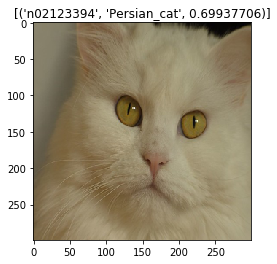

In [37]:
import tensorflow as tf
data = get_image_data()
req = data[0:1]
r = sc.predict(data=req, payload_type='tftensor')

preds = tf.make_ndarray(r.response.data.tftensor)

label = decode_predictions(preds, top=1)
plt.title(label[0])
plt.imshow(data[0])

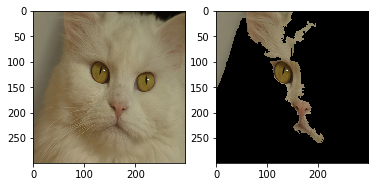

In [39]:
req = np.expand_dims(data[0], axis=0)
r = sc.explain(data=req, predictor="default", transport="rest", payload_type='ndarray', client_return_type="dict")

f, axarr = plt.subplots(1, 2)

axarr[0].imshow(data[0])
axarr[1].imshow(r.response["data"]["anchor"])
plt.show()


In [40]:
!kubectl delete -f resources/imagenet_explainer_grpc.yaml

seldondeployment.machinelearning.seldon.io "image" deleted


## Tensorflow CIFAR10 Model

A full Kubeflow example with training of the model and explainer can be found in the [Kubeflow Pipelines project examples](https://github.com/kubeflow/pipelines/blob/master/samples/contrib/e2e-outlier-drift-explainer/seldon/README.md#cifar10-image-classification-model).

In [41]:
%%writefile resources/cifar10_explainer.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10-classifier
spec:
  protocol: tensorflow
  annotations:
    seldon.io/rest-timeout: "100000"
  predictors:
  - componentSpecs:
    graph:
      implementation: TENSORFLOW_SERVER
      modelUri: gs://seldon-models/tfserving/cifar10/resnet32
      name: cifar10-classifier
      logger:
         mode: all
    explainer:
      type: AnchorImages
      modelUri: gs://seldon-models/tfserving/cifar10/explainer-py36-0.5.2
    name: default
    replicas: 1

Overwriting resources/cifar10_explainer.yaml


In [42]:
!kubectl apply -f resources/cifar10_explainer.yaml

seldondeployment.machinelearning.seldon.io/cifar10-classifier created


In [43]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=cifar10-classifier -o jsonpath='{.items[0].metadata.name}')

Waiting for deployment "cifar10-classifier-default-0-cifar10-classifier" rollout to finish: 0 of 1 updated replicas are available...
deployment "cifar10-classifier-default-0-cifar10-classifier" successfully rolled out


In [44]:
!kubectl rollout status deploy/cifar10-classifier-default-explainer

deployment "cifar10-classifier-default-explainer" successfully rolled out


In [45]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

url = 'https://storage.googleapis.com/seldon-models/alibi-detect/classifier/'
path_model = os.path.join(url, "cifar10", "resnet32", 'model.h5')
save_path = tf.keras.utils.get_file("resnet32", path_model)
model = tf.keras.models.load_model(save_path)

train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

W1028 10:45:24.713589 140410531391232 deprecation.py:506] From /home/clive/anaconda3/envs/seldon-core/lib/python3.6/site-packages/tensorflow_core/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1028 10:45:24.779426 140410531391232 deprecation.py:506] From /home/clive/anaconda3/envs/seldon-core/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


{
    "predictions": [[8.98417127e-08, 1.35163679e-12, 5.20754609e-13, 9.01404201e-05, 4.04729e-12, 0.999909759, 9.77382086e-09, 1.30629796e-09, 5.39957488e-12, 3.7917457e-14]
    ]
}


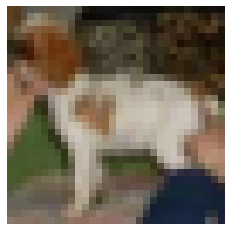

class: dog
prediction: dog


In [46]:
from subprocess import run, Popen, PIPE
import json
import numpy as np
idx=12
test_example=X_test[idx:idx+1].tolist()
payload='{"instances":'+f"{test_example}"+' }'
cmd=f"""curl -d '{payload}' \
   http://localhost:8003/seldon/seldon/cifar10-classifier/v1/models/cifar10-classifier/:predict \
   -H "Content-Type: application/json"
"""
ret = Popen(cmd, shell=True,stdout=PIPE)
raw = ret.stdout.read().decode("utf-8")
print(raw)
res=json.loads(raw)
arr=np.array(res["predictions"])
X = X_test[idx].reshape(1, 32, 32, 3)
plt.imshow(X.reshape(32, 32, 3))
plt.axis('off')
plt.show()
print("class:",class_names[y_test[idx][0]])
print("prediction:",class_names[arr[0].argmax()])

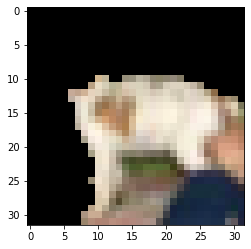

In [47]:
test_example=X_test[idx:idx+1].tolist()
payload='{"instances":'+f"{test_example}"+' }'
cmd=f"""curl -d '{payload}' \
   http://localhost:8003/seldon/seldon/cifar10-classifier-explainer/default/v1/models/cifar10-classifier:explain \
   -H "Content-Type: application/json"
"""
ret = Popen(cmd, shell=True,stdout=PIPE)
raw = ret.stdout.read().decode("utf-8")
explanation = json.loads(raw)
arr = np.array(explanation["data"]["anchor"])
plt.imshow(arr)

In [48]:
!kubectl delete -f resources/cifar10_explainer.yaml

seldondeployment.machinelearning.seldon.io "cifar10-classifier" deleted


## Wine Prediction Model with Shap Explainer

The model and explainer used here can be trained yourself following the full example in the [Kernel SHAP explanation for multinomial logistic regression models](https://docs.seldon.io/projects/alibi/en/latest/examples/kernel_shap_wine_lr.html) in the Alibi project documentation.

Note we used a python3.6 and version 0.5.2 of Alibi.

In [49]:
import shap
shap.initjs()

In [50]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
wine = load_wine()
data = wine.data
target = wine.target
target_names = wine.target_names
feature_names  = wine.feature_names
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=0,
                                                   )
print("Training records: {}".format(X_train.shape[0]))
print("Testing records: {}".format(X_test.shape[0]))

Training records: 142
Testing records: 36


In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [52]:
%%writefile resources/wine_explainer.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: wine
spec:
  annotations:
    seldon.io/rest-timeout: "100000"
  predictors:
  - graph:
      children: []
      implementation: SKLEARN_SERVER
      modelUri: gs://seldon-models/sklearn/wine/model-py36-0.23.2
      name: classifier
      parameters:
        - name: method
          type: STRING
          value: decision_function       
    explainer:
      type: KernelShap
      modelUri: gs://seldon-models/sklearn/wine/kernel_shap_py36_alibi_0.5.5
    name: default
    replicas: 1

Overwriting resources/wine_explainer.yaml


In [53]:
!kubectl apply -f resources/wine_explainer.yaml

seldondeployment.machinelearning.seldon.io/wine created


In [54]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=wine -o jsonpath='{.items[0].metadata.name}')

Waiting for deployment "wine-default-0-classifier" rollout to finish: 0 of 1 updated replicas are available...
deployment "wine-default-0-classifier" successfully rolled out


In [55]:
!kubectl rollout status deploy/wine-default-explainer

deployment "wine-default-explainer" successfully rolled out


In [56]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(deployment_name="wine",namespace="seldon", gateway="ambassador", gateway_endpoint="localhost:8003")

Use python client library to get a prediction.

In [57]:
data = np.array([[-0.24226334,  0.26757916,  0.42085937,  0.7127641 ,  0.84067236,
       -1.27747161, -0.60582812, -0.9706341 , -0.5873972 ,  2.42611713,
       -2.06608025, -1.55017035, -0.86659858]])
r = sc.predict(data=data)
print(r.response)
class_idx = np.argmax(np.array(r.response["data"]["tensor"]["values"]))

{'data': {'names': ['t:0', 't:1', 't:2'], 'tensor': {'shape': [1, 3], 'values': [-0.203700284044519, 0.8934751316557469, 2.2237213335499804]}}, 'meta': {}}


Use curl to get a prediction.

In [58]:
!curl -d '{"data": {"ndarray":[[-0.24226334,  0.26757916,  0.42085937,  0.7127641 ,  0.84067236, -1.27747161, -0.60582812, -0.9706341 , -0.5873972 ,  2.42611713, -2.06608025, -1.55017035, -0.86659858]]}}' \
   -X POST http://localhost:8003/seldon/seldon/wine/api/v1.0/predictions \
   -H "Content-Type: application/json"

{"data":{"names":["t:0","t:1","t:2"],"ndarray":[[-0.203700284044519,0.8934751316557469,2.2237213335499804]]},"meta":{}}


Use python client library to get an explanation.

In [59]:
import json
data = np.array([[-0.24226334,  0.26757916,  0.42085937,  0.7127641 ,  0.84067236,
       -1.27747161, -0.60582812, -0.9706341 , -0.5873972 ,  2.42611713,
       -2.06608025, -1.55017035, -0.86659858]])
explanation = sc.explain(deployment_name="wine", predictor="default", data=data)
explanation = explanation.response
expStr = json.dumps(explanation)

In [60]:
from alibi.api.interfaces import Explanation
explanation = Explanation.from_json(expStr)

In [61]:
explanation.shap_values = np.array(explanation.shap_values)
explanation.raw["instances"] = np.array(explanation.raw["instances"])

In [62]:
idx=0
shap.force_plot(
    explanation.expected_value[class_idx], 
    explanation.shap_values[class_idx][idx, :], 
    explanation.raw['instances'][idx][None, :],  
    explanation.feature_names,
)

Using curl to get an explanation.

In [63]:
!curl -X POST -H 'Content-Type: application/json' \
    -d '{"data": {"names": ["text"], "ndarray": [[-0.24226334,  0.26757916,  0.42085937,  0.7127641 ,  0.84067236, -1.27747161, -0.60582812, -0.9706341 , -0.5873972 ,  2.42611713, -2.06608025, -1.55017035, -0.86659858]]}}' \
    http://localhost:8003/seldon/seldon/wine-explainer/default/api/v1.0/explain | jq .

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4129  100  3916  100   213   1267     68  0:00:03  0:00:03 --:--:--  1267
{
  "meta": {
    "name": "KernelShap",
    "type": [
      "blackbox"
    ],
    "task": "classification",
    "explanations": [
      "local",
      "global"
    ],
    "params": {
      "link": "identity",
      "group_names": null,
      "grouped": false,
      "groups": null,
      "weights": null,
      "summarise_background": false,
      "summarise_result": false,
      "transpose": false,
      "kwargs": {}
    }
  },
  "data": {
    "shap_values": [
      [
        [
          -0.018454421208892513,
          0.012763470836013313,
          -0.001740270040221814,
          -0.07633537428284093,
          0.006251732078452754,
          -0.13734297799429607,
          -0.1184209545879712,
          0.016528383221730947,
          -0.03524430776

In [64]:
!kubectl delete -f resources/wine_explainer.yaml

seldondeployment.machinelearning.seldon.io "wine" deleted


## MNIST Model with Integrated Gradients Explainer

The model and explainer used here can be trained yourself following the full example in the [Integrated gradients for MNIST](https://docs.seldon.io/projects/alibi/en/latest/examples/integrated_gradients_mnist.html) in the Alibi project documentation.

Note we used a python3.6 and version 0.5.2 of Alibi.

In [65]:
%%writefile resources/mnist_rest_explainer.yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  name: tfserving
spec:
  name: mnist
  predictors:
  - graph:
      children: []
      implementation: TENSORFLOW_SERVER
      modelUri: gs://seldon-models/tfserving/mnist-model
      name: mnist-model
      parameters:
        - name: signature_name
          type: STRING
          value: predict_images
        - name: model_name
          type: STRING
          value: mnist-model
    explainer:
      type: IntegratedGradients
      modelUri: gs://seldon-models/keras/mnist
    name: default
    replicas: 1

Overwriting resources/mnist_rest_explainer.yaml


In [66]:
!kubectl apply -f resources/mnist_rest_explainer.yaml

seldondeployment.machinelearning.seldon.io/tfserving created


In [67]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=tfserving -o jsonpath='{.items[0].metadata.name}')

Waiting for deployment "tfserving-default-0-mnist-model" rollout to finish: 0 of 1 updated replicas are available...
deployment "tfserving-default-0-mnist-model" successfully rolled out


In [68]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test
test_labels = y_test.copy()
train_labels = y_train.copy()
                         
X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


In [69]:
nb_samples = 10
X_test_sample = X_test[:nb_samples]

In [70]:
import json
d = {"data": {"tensor":{"shape":[10,784],"values":X_test_sample.flatten().tolist()}}}
with open("input.json","w") as f:
    f.write(json.dumps(d))

In [71]:
res=!curl -s -H 'Content-Type: application/json' \
    -d @./input.json \
    http://localhost:8003/seldon/seldon/tfserving/api/v1.0/predictions 
res=json.loads(res[0])

In [72]:
predictions = np.array(res["data"]["tensor"]["values"]).reshape(res["data"]["tensor"]["shape"])
predictions = predictions.argmax(axis=1)

In [73]:
predictions

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9])

In [74]:
import json
d = {"data": {"tensor":{"shape":X_test_sample.shape,"values":X_test_sample.flatten().tolist()}}}
with open("input.json","w") as f:
    f.write(json.dumps(d))

In [75]:
res=!curl -s -H 'Content-Type: application/json' \
    -d @./input.json \
    http://localhost:8003/seldon/seldon/tfserving-explainer/default/api/v1.0/explain
res=json.loads(res[0]) 

In [76]:
attrs = np.array(res["data"]["attributions"])

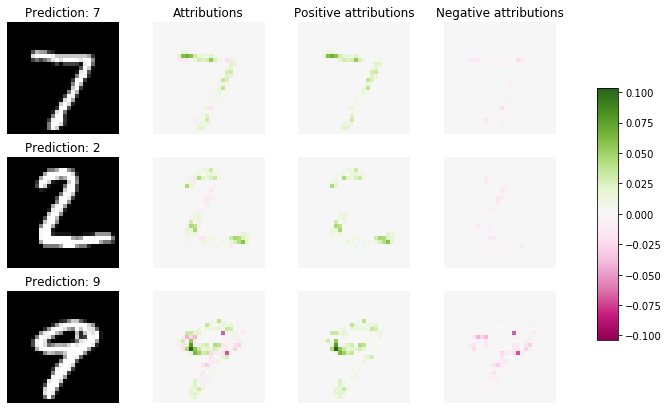

In [77]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 7))
image_ids = [0, 1, 9]
cmap_bound = np.abs(attrs[[0, 1, 9]]).max()

for row, image_id in enumerate(image_ids):
    # original images
    ax[row, 0].imshow(X_test[image_id].squeeze(), cmap='gray')
    ax[row, 0].set_title(f'Prediction: {predictions[image_id]}')
    
    # attributions
    attr = attrs[image_id]
    im = ax[row, 1].imshow(attr.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')
    
    # positive attributions
    attr_pos = attr.clip(0, 1)
    im_pos = ax[row, 2].imshow(attr_pos.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')
    
    # negative attributions
    attr_neg = attr.clip(-1, 0)
    im_neg = ax[row, 3].imshow(attr_neg.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')
    
ax[0, 1].set_title('Attributions');
ax[0, 2].set_title('Positive attributions');
ax[0, 3].set_title('Negative attributions');

for ax in fig.axes:
    ax.axis('off')

fig.colorbar(im, cax=fig.add_axes([0.95, 0.25, 0.03, 0.5]));

In [78]:
!kubectl delete -f resources/mnist_rest_explainer.yaml

seldondeployment.machinelearning.seldon.io "tfserving" deleted


## XGBoost Model with TreeShap Explainer

The model and explainer used here can be trained yourself following the full example in the [Explaining Tree Models with Interventional Feature Perturbation Tree SHAP](https://docs.seldon.io/projects/alibi/en/latest/examples/interventional_tree_shap_adult_xgb.html) in the Alibi project documentation.

Note we used a python3.6 and version 0.5.2 of Alibi.

In [79]:
%%writefile resources/income_explainer.yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  name: income
spec:
  predictors:
  - graph:
      children: []
      implementation: XGBOOST_SERVER
      modelUri: gs://seldon-models/xgboost/adult/model_1.0.2
      name: income-model
    explainer:
      type: TreeShap
      modelUri: gs://seldon-models/xgboost/adult/tree_shap_py368_alibi_0.5.5
    name: default
    replicas: 1

Overwriting resources/income_explainer.yaml


In [80]:
!kubectl apply -f resources/income_explainer.yaml

seldondeployment.machinelearning.seldon.io/income created


In [81]:
!kubectl rollout status deploy/$(kubectl get deploy -l seldon-deployment-id=income -o jsonpath='{.items[0].metadata.name}')

Waiting for deployment "income-default-0-income-model" rollout to finish: 0 of 1 updated replicas are available...
deployment "income-default-0-income-model" successfully rolled out


In [82]:
from seldon_core.seldon_client import SeldonClient
import numpy as np
sc = SeldonClient(deployment_name="income",namespace="seldon", gateway="ambassador", gateway_endpoint="localhost:8003")

Use python client library to get a prediction.

In [83]:
data = np.array([[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60,  9]])
r = sc.predict(data=data)
print(r.response)

{'data': {'names': [], 'tensor': {'shape': [1], 'values': [-1.2381880283355713]}}, 'meta': {}}


Use python client library to get an explanation.

In [84]:
import json
data = np.array([[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60,  9]])
res = sc.explain(deployment_name="income", predictor="default", data=data)
explanation = res.response
explanationStr = json.dumps(explanation)

In [85]:
from alibi.api.interfaces import Explanation
explanation = Explanation.from_json(explanationStr)

In [86]:
explanation.shap_values = np.array(explanation.shap_values)
explanation.raw["instances"] = np.array(explanation.raw["instances"])

In [87]:
def decode_data(X, feature_names, category_map):
    """
    Given an encoded data matrix `X` returns a matrix where the 
    categorical levels have been replaced by human readable categories.
    """
    
    # expect 2D array
    if len(X.shape) == 1:
        X = X.reshape(1, -1)
    
    X_new = np.zeros(X.shape, dtype=object)
    # Check if a column is categorical and replace it with values from category map
    for idx, name in enumerate(feature_names):
        categories = category_map.get(str(idx), None)
        if categories:
            for j, category in enumerate(categories):
                encoded_vals = X[:, idx] == j
                X_new[encoded_vals, idx] = category
        else:
            X_new[:, idx] = X[:, idx]
        
    return X_new

In [88]:
decoded_features = decode_data(data,explanation.feature_names,explanation.categorical_names)

In [89]:
import shap
shap.initjs()

In [90]:
shap.force_plot(
    explanation.expected_value[0], # 0 is a class index but we have single-output model
    explanation.shap_values[0][0, :] , 
    decoded_features,  
    explanation.feature_names,
)

In [91]:
!kubectl delete -f resources/income_explainer.yaml

seldondeployment.machinelearning.seldon.io "income" deleted
